<a href="https://colab.research.google.com/github/sammyamajumdar/Kaggle_Challenges/blob/master/Chest_xray_pneumonia_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sammyamajumdar","key":"8bed6789a501534ffe03f24b72485d0b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 40.5MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.5MB/s]


In [8]:
from zipfile import ZipFile
file_name = "chest-xray-pneumonia.zip"
with ZipFile(file_name) as zip:
    zip.extractall()
    print("Done!")

Done!


In [9]:
train_dir = "/content/chest_xray/train"
train_normal_dir = "/content/chest_xray/train/NORMAL"
train_pneumonia_dir = "/content/chest_xray/train/PNEUMONIA"

validation_dir = "/content/chest_xray/val"
validation_normal_dir = "/content/chest_xray/val/NORMAL"
validation_pneumonia_dir = "/content/chest_xray/val/PNEUMONIA"

test_dir = "/content/chest_xray/test"
test_normal_dir = "/content/chest_xray/test/NORMAL"
test_pneumonia_dir = "/content/chest_xray/test/PNEUMONIA"

print(f"Training samples : {len(os.listdir(train_normal_dir))+len(os.listdir(train_pneumonia_dir))}")
print(f"Validation samples : {len(os.listdir(validation_normal_dir))+len(os.listdir(validation_pneumonia_dir))}")
print(f"Testing samples : {len(os.listdir(test_normal_dir))+len(os.listdir(test_pneumonia_dir))}")

Training samples : 5216
Validation samples : 16
Testing samples : 624


In [10]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  fill_mode = "nearest")
validation_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (300,300),
    batch_size = 32,
    class_mode = "binary"
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (300,300),
    batch_size = 8,
    class_mode = "binary"
)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(300,300),
                                                  batch_size=16,
                                                  class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
pretrained_model = InceptionV3(input_shape = (300,300,3), include_top=False, weights=None)
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
local_weights_file =  "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pretrained_model.load_weights(local_weights_file)
for layer in pretrained_model.layers:
    layer.trainable = False
#pretrained_model.summary()
last_layer = pretrained_model.get_layer("mixed7")
print(f"Last layer output shape : {last_layer.output_shape}")
last_layer_output = last_layer.output

--2020-08-11 11:56:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   142MB/s    in 0.6s    

2020-08-11 11:56:44 (142 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Last layer output shape : (None, 17, 17, 768)


In [12]:
x = layers.Flatten()(last_layer_output)
x = layers.Dense(1024, activation = "relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = "sigmoid")(x)
model = Model(pretrained_model.input, x)
model.compile(optimizer = Adam(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs = {}):
        if (logs.get("accuracy")>.98):
            print("\nReached 98% training so stopped training!")
            self.model.stop_training = True
callbacks = myCallback()

In [15]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data = validation_generator,
                    validation_steps = 2,
                    callbacks = [callbacks])

Epoch 1/50
163/163 [==============================] - 175s 1s/step - loss: 0.2482 - accuracy: 0.9089 - val_loss: 0.2929 - val_accuracy: 0.8125
Epoch 2/50
163/163 [==============================] - 172s 1s/step - loss: 0.1336 - accuracy: 0.9465 - val_loss: 0.2001 - val_accuracy: 0.9375
Epoch 3/50
163/163 [==============================] - 170s 1s/step - loss: 0.1208 - accuracy: 0.9519 - val_loss: 0.2101 - val_accuracy: 0.8750
Epoch 4/50
163/163 [==============================] - 171s 1s/step - loss: 0.0994 - accuracy: 0.9632 - val_loss: 0.1594 - val_accuracy: 0.9375
Epoch 5/50
163/163 [==============================] - 171s 1s/step - loss: 0.1006 - accuracy: 0.9636 - val_loss: 0.2393 - val_accuracy: 0.8125
Epoch 6/50
163/163 [==============================] - 170s 1s/step - loss: 0.0935 - accuracy: 0.9626 - val_loss: 0.1366 - val_accuracy: 1.0000
Epoch 7/50
163/163 [==============================] - 169s 1s/step - loss: 0.0965 - accuracy: 0.9615 - val_loss: 0.1367 - val_accuracy: 1.0000

In [16]:
test_loss, test_accuracy = model.evaluate_generator(test_generator)
print(f"model 1 accuracy is : {round(test_accuracy,2)*100}%")

Instructions for updating:
Please use Model.evaluate, which supports generators.
model 1 accuracy is : 92.0%


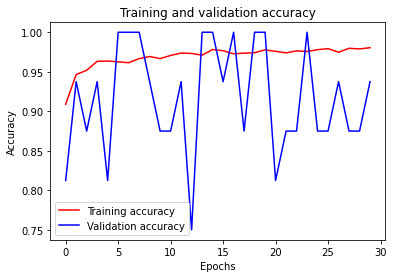

<Figure size 432x288 with 0 Axes>

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

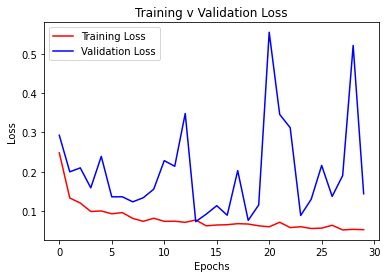

In [18]:
plt.plot(epochs, loss, "r", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.title("Training v Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()